<a href="https://colab.research.google.com/github/deepiitk1/Pepper_Bell_Disease_Detection/blob/master/3_Pepper_bell_disease_detection_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import random
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
IMAGE_SIZE = [224, 224]
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/Computer Vision/3. Pepper_bell (Kaggle Dataset)/Data/train&val'
folders = glob('/content/drive/My Drive/Colab Notebooks/Computer Vision/3. Pepper_bell (Kaggle Dataset)/Data/train&val/*')
len(folders)

2

### **Import Dataset using ImageDataGenerator**

In [4]:
datagen = ImageDataGenerator(validation_split=0.2,  rescale=1./255)

training_set = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset='training' 
    
)

val_set = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset='validation'
)

print(len(training_set))

Found 1814 images belonging to 2 classes.
Found 452 images belonging to 2 classes.
57


In [5]:
print(val_set.class_indices)
print(training_set.class_indices)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}
{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1}


### **Examples of Unhealthy and Healthy Pepper Bell**



Pepper bell Unhealthy


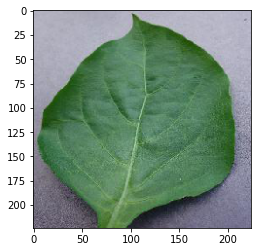

In [6]:
plt.imshow(training_set[0][0][0])
print('Pepper bell Unhealthy')

Pepper bell healthy


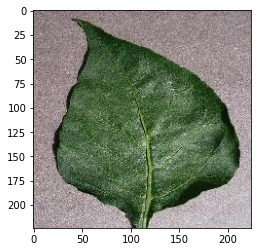

In [7]:
plt.imshow(training_set[50][0][0])
print('Pepper bell healthy')

### **Transfer Learning: InceptionV3**

In [8]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### **Training**

In [9]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
57/57 [==============================] - 9s 153ms/step - loss: 1.4609 - accuracy: 0.8473 - val_loss: 1.3379 - val_accuracy: 0.8783
Epoch 2/20
57/57 [==============================] - 7s 125ms/step - loss: 0.2018 - accuracy: 0.9658 - val_loss: 0.5091 - val_accuracy: 0.9535
Epoch 3/20
57/57 [==============================] - 7s 127ms/step - loss: 0.0537 - accuracy: 0.9862 - val_loss: 0.3558 - val_accuracy: 0.9558
Epoch 4/20
57/57 [==============================] - 7s 126ms/step - loss: 0.0299 - accuracy: 0.9890 - val_loss: 0.3703 - val_accuracy: 0.9535
Epoch 5/20
57/57 [==============================] - 7s 124ms/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.3921 - val_accuracy: 0.9535
Epoch 6/20
57/57 [==============================] - 7s 124ms/step - loss: 7.3081e-04 - accuracy: 1.0000 - val_loss: 0.3546 - val_accuracy: 0.9535
Epoch 7/20
57/57 [==============================] - 7s 127ms/step - 

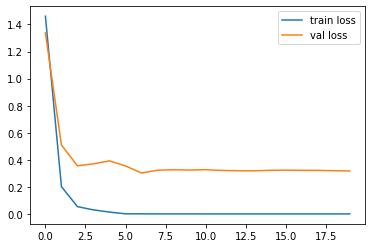

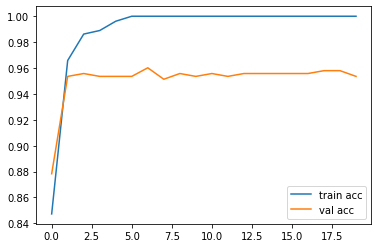

<Figure size 432x288 with 0 Axes>

In [10]:
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### **Testing**

In [11]:
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/Computer Vision/3. Pepper_bell (Kaggle Dataset)/Data/test'
datagen = ImageDataGenerator(rescale=1./255)

test_set = datagen.flow_from_directory(
    TEST_DIR,
    shuffle = False,
    target_size = (224, 224)
) 

predictions_test = model.predict(test_set)
y_pred_test = np.argmax(predictions_test, axis=1)
y_true_test = test_set.classes

Found 209 images belonging to 2 classes.


In [12]:
f1_score(y_true_test, y_pred_test)

0.9423076923076923

Text(42.0, 0.5, 'Truth')

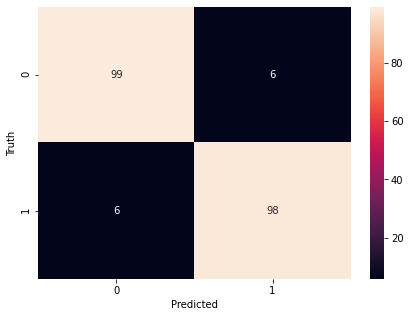

In [13]:
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

### **Classification Report**

In [14]:
print('classification_report :\n\n',classification_report(y_true_test,y_pred_test))

classification_report :

               precision    recall  f1-score   support

           0       0.94      0.94      0.94       105
           1       0.94      0.94      0.94       104

    accuracy                           0.94       209
   macro avg       0.94      0.94      0.94       209
weighted avg       0.94      0.94      0.94       209



### **Some test examples randomly chosen from test dataset**

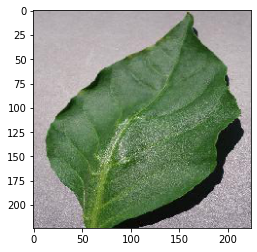

Test image number: 156
Actual label - Healthy
Prediction - Healthy


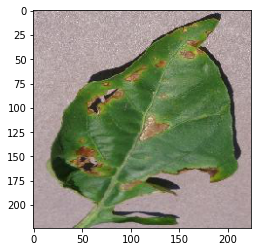

Test image number: 41
Actual label - Unhealthy
Prediction - Unhealthy


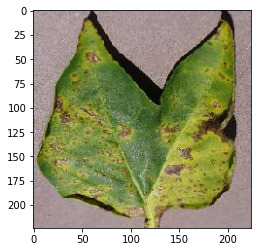

Test image number: 33
Actual label - Unhealthy
Prediction - Unhealthy


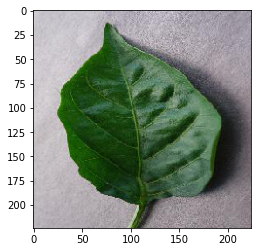

Test image number: 109
Actual label - Healthy
Prediction - Healthy


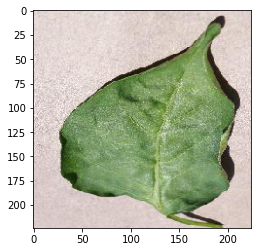

Test image number: 162
Actual label - Healthy
Prediction - Healthy


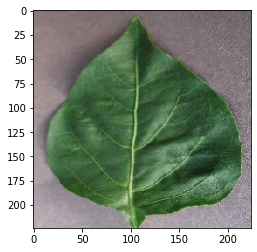

Test image number: 117
Actual label - Healthy
Prediction - Healthy


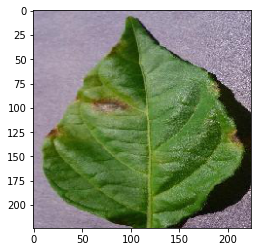

Test image number: 64
Actual label - Unhealthy
Prediction - Healthy


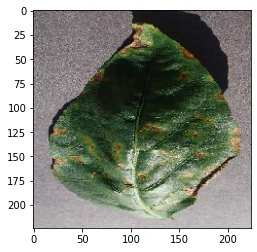

Test image number: 76
Actual label - Unhealthy
Prediction - Unhealthy


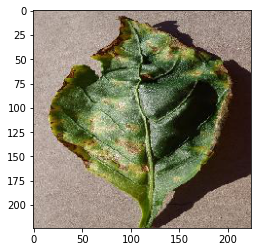

Test image number: 78
Actual label - Unhealthy
Prediction - Unhealthy


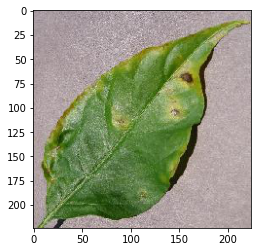

Test image number: 71
Actual label - Unhealthy
Prediction - Unhealthy


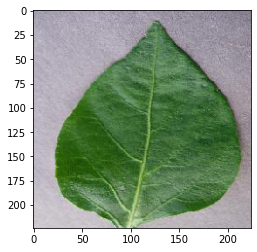

Test image number: 181
Actual label - Healthy
Prediction - Healthy


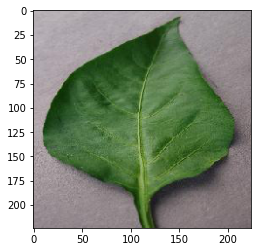

Test image number: 136
Actual label - Healthy
Prediction - Healthy


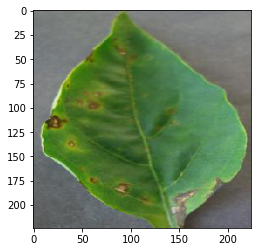

Test image number: 12
Actual label - Unhealthy
Prediction - Unhealthy


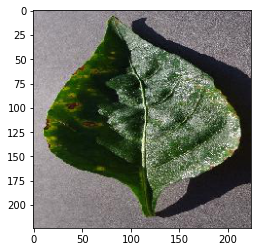

Test image number: 19
Actual label - Unhealthy
Prediction - Unhealthy


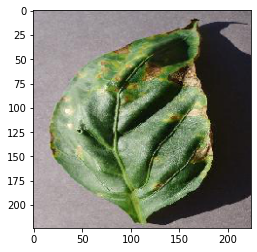

Test image number: 77
Actual label - Unhealthy
Prediction - Unhealthy


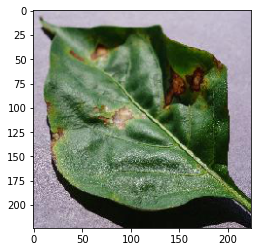

Test image number: 10
Actual label - Unhealthy
Prediction - Unhealthy


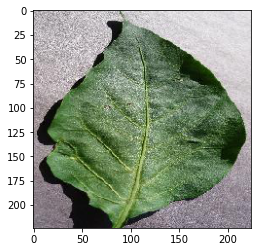

Test image number: 185
Actual label - Healthy
Prediction - Healthy


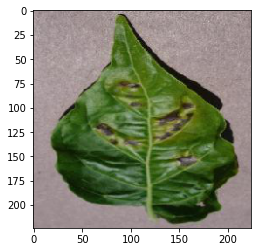

Test image number: 44
Actual label - Unhealthy
Prediction - Unhealthy


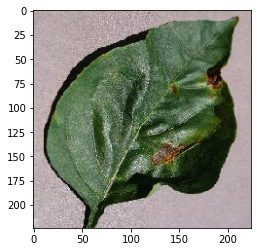

Test image number: 67
Actual label - Unhealthy
Prediction - Unhealthy


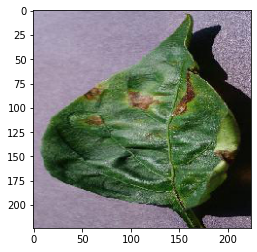

Test image number: 48
Actual label - Unhealthy
Prediction - Unhealthy


In [15]:
for i in range (20):
  test_img_batch_no = random.randint(0,5)         # Test image batch number
  img_no = random.randint(0,31)                   # Image number within batch
  test_img_number = test_img_batch_no*32 + img_no
  plt.imshow(test_set[test_img_batch_no][0][img_no])
  plt.show()

  print('Test image number:', test_img_number)
  if y_true_test[test_img_number ] ==0:
    print('Actual label - Unhealthy')
  else:
    print('Actual label - Healthy')

  prediction = y_pred_test[test_img_number]
  if prediction == 0:
    print('Prediction - Unhealthy')
  else:
    print('Prediction - Healthy')